In [1]:
import numpy as np
from cvxopt import matrix, solvers, sparse
from scipy.sparse import dia_matrix, diags
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.pyplot as plt
from spline_regressor import get_curve, scan_alphas
import pandas 

np.random.seed(0)
%matplotlib inline
solvers.options['show_progress'] = False

size=16
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)


# Smooth isotonic concave arbitrary regression

In this notebook I'll be working through a set of regressions on different types of functions. Random data will be generated with different levels of sampling and noise. Each sample will have 1 result that is a dud. Sometimes in science, one of the measurements just fails. All x values will be unique, so a curve could actually go through each and every point. I'll be optimizing an arbitry function, $f$, with an objective of the form:

\begin{align}
\text{Argmin}_f \sum_i \left[ f(x_i) - y_i\right]^2 + \alpha \int \left[\frac{\partial^2 f(x)}{\partial x^2}\right]^2dx
\end{align}

I scan along $\alpha$ values and choose the curve with the highest Bayesian Information Criterion (BIC). A high smoothing penalty ($\alpha$) implies a straight line, a low smoothing penalty ($\alpha$) implies a very wavy sort of curve. I'll be starting with an isotonic concave curve like you might expect with an assay that somewhat follows an enzymatic activity curve.

In [2]:
min_val = 0 #lower bound of curve to fit
max_val = 10000 #upper bound of curve to fit
n_gridpoints = 100 #number of grid points to fit, higher is better but slower
alphas = np.logspace(0,12,30) #smoothing penalties to consider

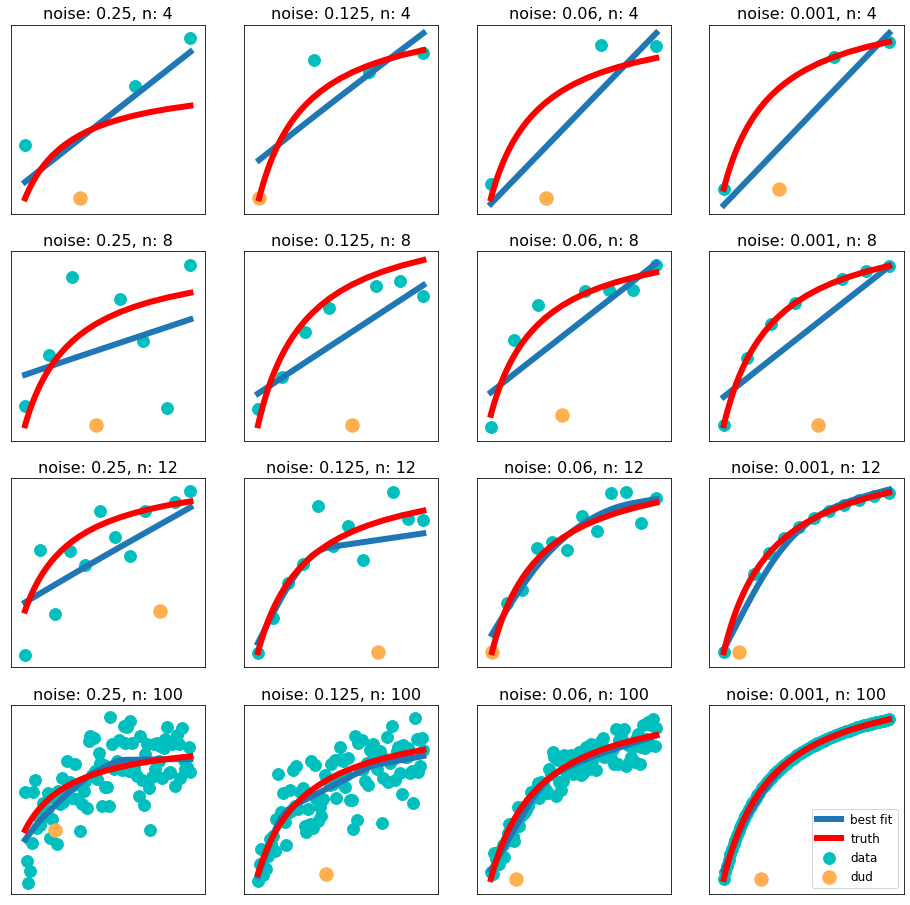

In [3]:
true_x = np.logspace(-2,4,100)
true_fx = lambda x:x/(3000+x)
true_y = true_fx(true_x)

fig,axes = plt.subplots(4,4,figsize=(16,16))
for ii, n in enumerate([4,8,12,100]):
    for jj, noise in enumerate([0.25,0.125,0.06,0.001]):
        x = np.linspace(0, 1e4, n)
        y = true_fx(x) + np.random.randn(len(x))*noise
        catastrophe = np.random.randint(n)
        y[catastrophe] = 0.
        BICs, x_grid, fit_y, fx, dfdx, df2dx2 = scan_alphas(x, y, n_gridpoints, alphas, isotonic=1, convexity=-1, min_x = min_val, max_x=max_val) 

        axes[ii,jj].plot(x_grid, fit_y, label='best fit',lw=6)
        axes[ii,jj].plot(true_x, true_y, label='truth',lw=6,c='r')
        axes[ii,jj].scatter(x,y,s=140,c='c',label='data')
        axes[ii,jj].scatter(x[catastrophe],y[catastrophe],s=180,c='#FFAF4F',label='dud')
        axes[ii,jj].set_title(f'noise: {noise}, n: {n}')
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

axes[ii,jj].legend()
plt.show()
plt.close()

## Smooth isotonic concave arbitrary regression with known smoothing penalty

Let's say you alread know the alpha as in the last curve from the previous section (```alpha=alphas[np.argmax(BICs)]```), then you can just perform a single curve fit.

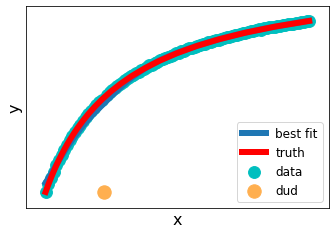

In [4]:
x_grid, fit_y, fx, dfdx, df2dx2 = get_curve(x, y, n_gridpoints, alpha=alphas[np.argmax(BICs)], isotonic=1, convexity=-1)


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(x_grid, fit_y, label='best fit',lw=6)
ax.plot(true_x, true_y, label='truth',lw=6,c='r')
ax.scatter(x,y,s=140,c='c',label='data')
ax.scatter(x[catastrophe],y[catastrophe],s=180,c='#FFAF4F',label='dud')
plt.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
plt.close()


Obviously, as the data get better the curve fitting gets better, but I wanted to stress my algorithm to show that it indeed works. I agree with the curves it's generating, even when it is straight or deviates from the true curve. 

# Smooth isotonic convex arbitrary regression

Here's another example with a cubic function. Fitting is now convex.

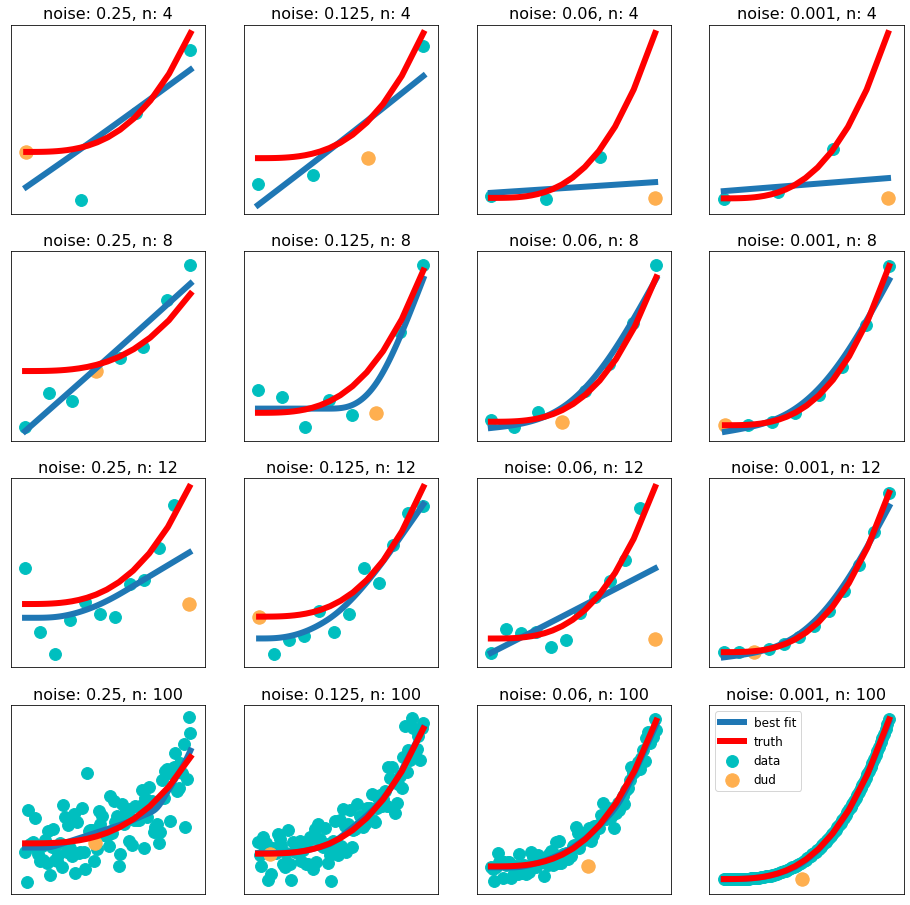

In [5]:
true_x = np.logspace(-2,4,100)
true_fx = lambda in_x:in_x**3/1e12
true_y = true_fx(true_x)

fig,axes = plt.subplots(4,4,figsize=(16,16))
for ii, n in enumerate([4,8,12,100]):
    for jj, noise in enumerate([0.25,0.125,0.06,0.001]):
        x = np.linspace(0, 1e4, n)
        y = true_fx(x) + np.random.randn(len(x))*noise
        catastrophe = np.random.randint(n)
        y[catastrophe] = 0.
        BICs, x_grid, fit_y, fx, dfdx, df2dx2 = scan_alphas(x, y, n_gridpoints, alphas, isotonic=1, convexity=1, min_x = min_val, max_x=max_val) 

        axes[ii,jj].plot(x_grid, fit_y, label='best fit',lw=6)
        axes[ii,jj].plot(true_x, true_y, label='truth',lw=6,c='r')
        axes[ii,jj].scatter(x,y,s=140,c='c',label='data')
        axes[ii,jj].scatter(x[catastrophe],y[catastrophe],s=180,c='#FFAF4F',label='dud')
        axes[ii,jj].set_title(f'noise: {noise}, n: {n}')
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

axes[ii,jj].legend()
plt.show()
plt.close()

# Isotonic regression
The next curve is no longer convex or concave, and not really isotonic, but let's treat it as an isotonic curve.

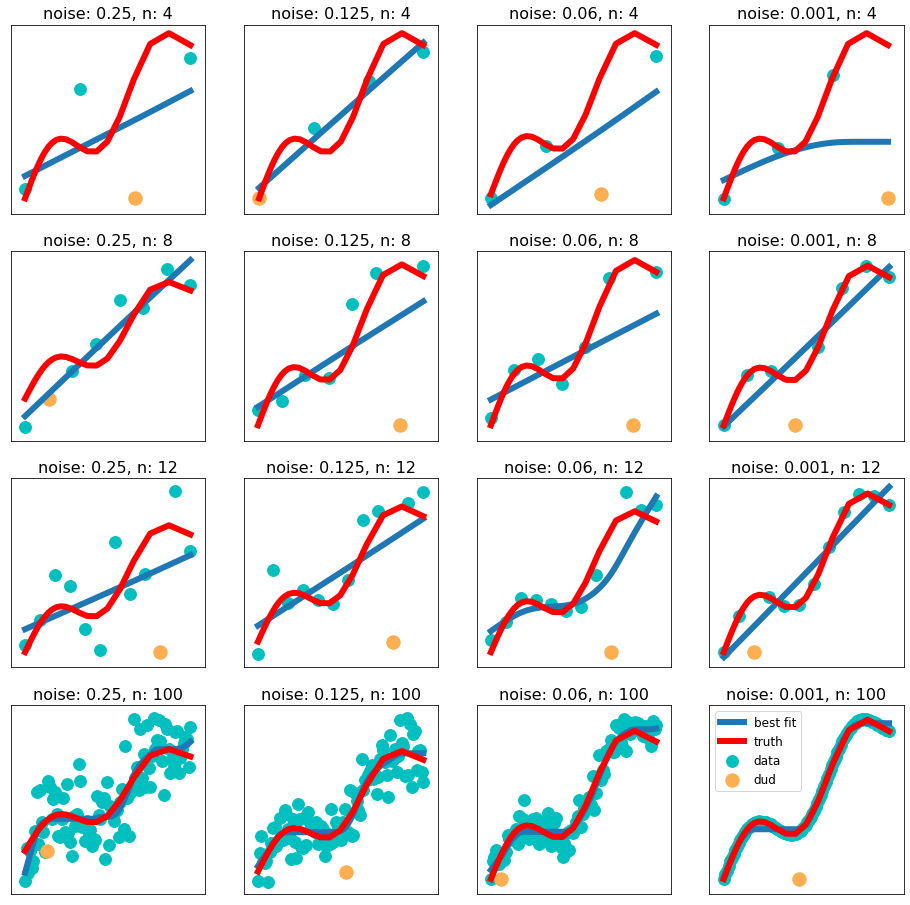

In [6]:
true_x = np.logspace(-2,4,100)
true_fx = lambda in_x:in_x/1e4 + np.sin(in_x/1e3)/6
true_y = true_fx(true_x)

fig,axes = plt.subplots(4,4,figsize=(16,16))
for ii, n in enumerate([4,8,12,100]):
    for jj, noise in enumerate([0.25,0.125,0.06,0.001]):
        x = np.linspace(0, 1e4, n)
        y = true_fx(x) + np.random.randn(len(x))*noise
        catastrophe = np.random.randint(n)
        y[catastrophe] = 0.
        BICs, x_grid, fit_y, fx, dfdx, df2dx2 = scan_alphas(x, y, n_gridpoints, alphas, isotonic=1, convexity=0, min_x = min_val, max_x=max_val) 

        axes[ii,jj].plot(x_grid, fit_y, label='best fit',lw=6)
        axes[ii,jj].plot(true_x, true_y, label='truth',lw=6,c='r')
        axes[ii,jj].scatter(x,y,s=140,c='c',label='data')
        axes[ii,jj].scatter(x[catastrophe],y[catastrophe],s=180,c='#FFAF4F',label='dud')
        axes[ii,jj].set_title(f'noise: {noise}, n: {n}')
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

axes[ii,jj].legend()
plt.show()
plt.close()

# Isotonically decreasing curve
Yes this regression can also go down!

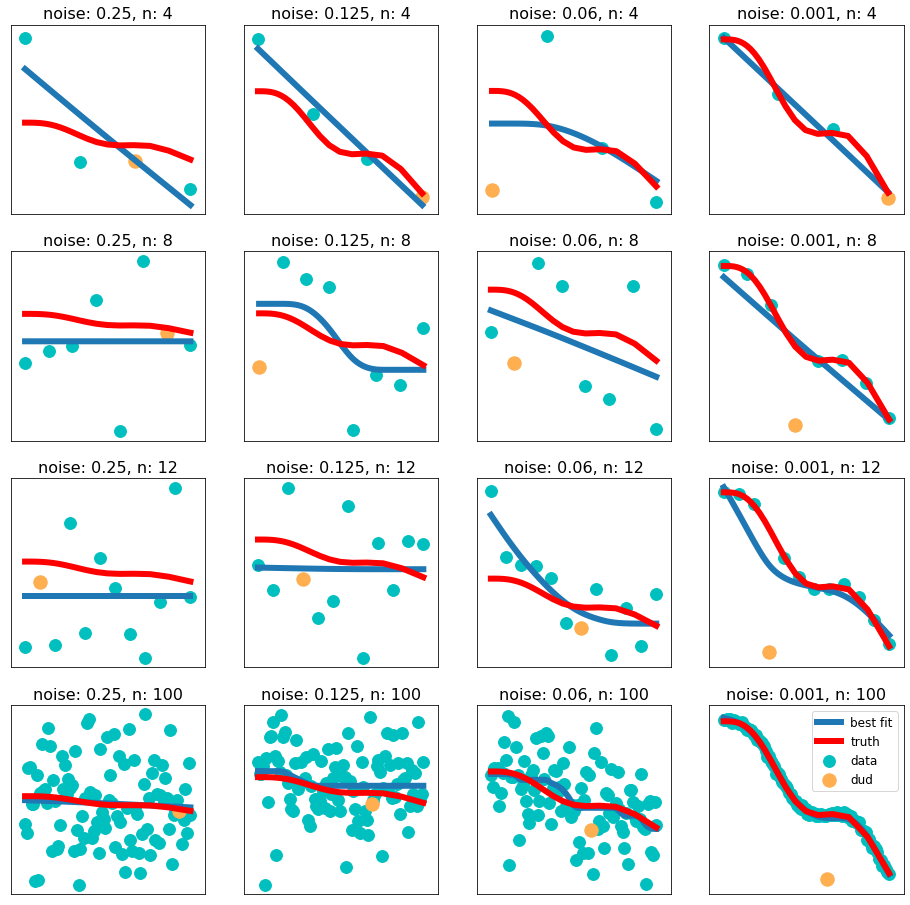

In [7]:
true_x = np.logspace(-2,4,100)
true_fx = lambda in_x:1./(in_x/1e5+1) + np.sin(in_x/1e3)/100
true_y = true_fx(true_x)
fig,axes = plt.subplots(4,4,figsize=(16,16))
for ii, n in enumerate([4,8,12,100]):
    for jj, noise in enumerate([0.25,0.125,0.06,0.001]):
        x = np.linspace(0, 1e4, n)
        y = true_fx(x) + np.random.randn(len(x))*noise
        catastrophe = np.random.randint(n)
        y[catastrophe] = 0.9
        BICs, x_grid, fit_y, fx, dfdx, df2dx2 = scan_alphas(x, y, n_gridpoints, alphas, isotonic=-1, convexity=0, min_x = min_val, max_x=max_val) 

        axes[ii,jj].plot(x_grid, fit_y, label='best fit',lw=6)
        axes[ii,jj].plot(true_x, true_y, label='truth',lw=6,c='r')
        axes[ii,jj].scatter(x,y,s=140,c='c',label='data')
        axes[ii,jj].scatter(x[catastrophe],y[catastrophe],s=180,c='#FFAF4F',label='dud')
        axes[ii,jj].set_title(f'noise: {noise}, n: {n}')
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

axes[ii,jj].legend()
plt.show()
plt.close()

# Convex regression
Now the curve is definitely not isotonic, but it is convex.

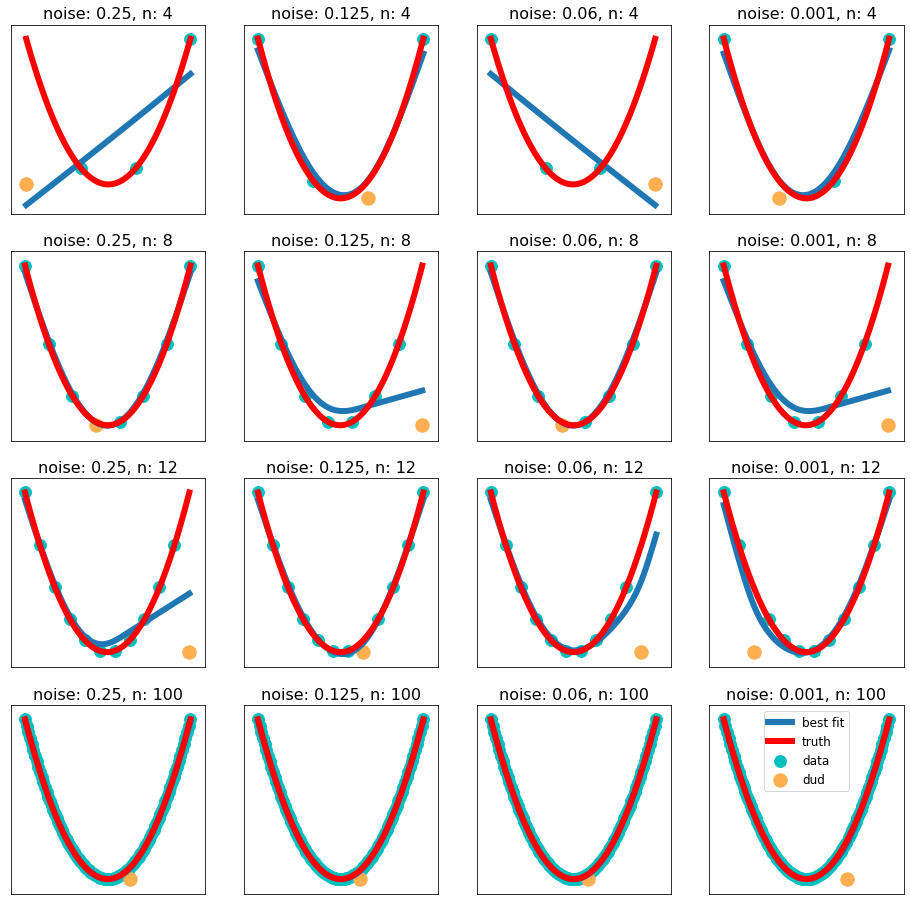

In [8]:
true_x = np.linspace(0,1e4,100)
true_fx = lambda in_x:(in_x-0.5e4)**2/1e4
true_y = true_fx(true_x)

fig,axes = plt.subplots(4,4,figsize=(16,16))
for ii, n in enumerate([4,8,12,100]):
    for jj, noise in enumerate([0.25,0.125,0.06,0.001]):
        x = np.linspace(0, 1e4, n)
        y = true_fx(x) + np.random.randn(len(x))*noise
        catastrophe = np.random.randint(n)
        y[catastrophe] = -0.1
        BICs, x_grid, fit_y, fx, dfdx, df2dx2 = scan_alphas(x, y, n_gridpoints, alphas, isotonic=0, convexity=1, min_x = min_val, max_x=max_val) 

        axes[ii,jj].plot(x_grid, fit_y, label='best fit',lw=6)
        axes[ii,jj].plot(true_x, true_y, label='truth',lw=6,c='r')
        axes[ii,jj].scatter(x,y,s=140,c='c',label='data')
        axes[ii,jj].scatter(x[catastrophe],y[catastrophe],s=180,c='#FFAF4F',label='dud')
        axes[ii,jj].set_title(f'noise: {noise}, n: {n}')
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

axes[ii,jj].legend()
plt.show()
plt.close()

# Smooth regression
Finally, I perform a normal smooth spline regression. There are probably better algorithms already built for this, but at least my algorithm doesn't seem to break when I try it.

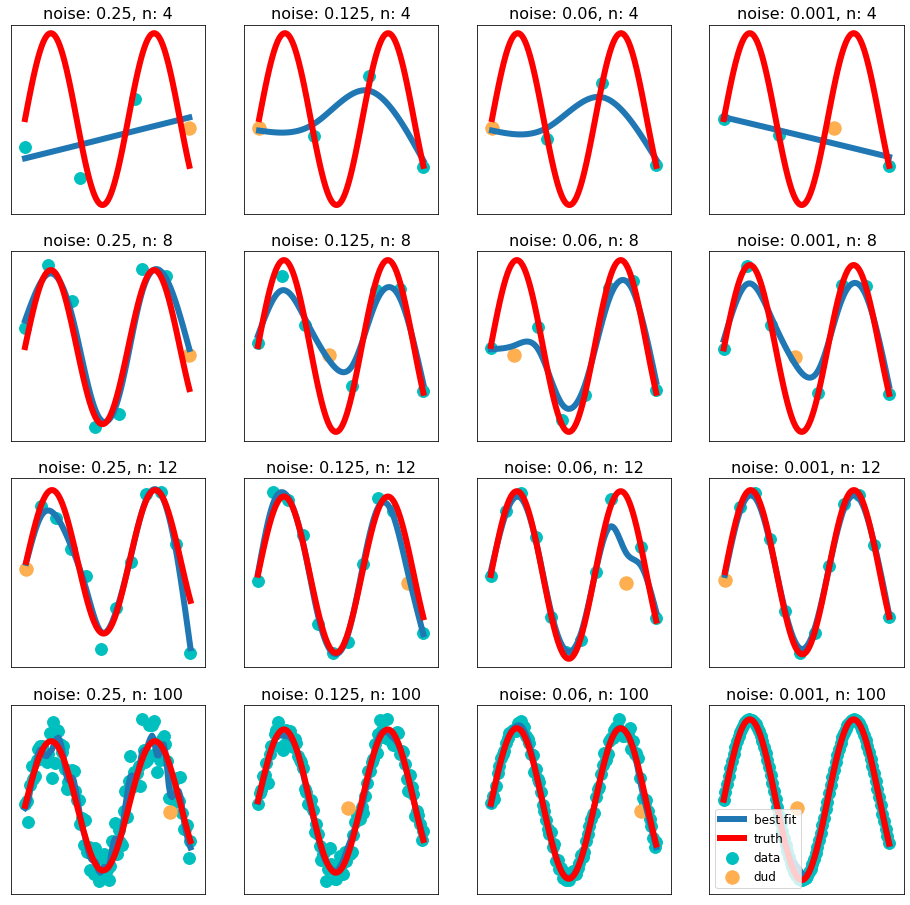

In [9]:
true_x = np.linspace(0,1e4,100)
true_fx = lambda in_x:np.sin(in_x/1e3)
true_y = true_fx(true_x)

fig,axes = plt.subplots(4,4,figsize=(16,16))
for ii, n in enumerate([4,8,12,100]):
    for jj, noise in enumerate([0.25,0.125,0.06,0.001]):
        x = np.linspace(0, 1e4, n)
        y = true_fx(x) + np.random.randn(len(x))*noise
        catastrophe = np.random.randint(n)
        y[catastrophe] = -0.1
        BICs, x_grid, fit_y, fx, dfdx, df2dx2 = scan_alphas(x, y, n_gridpoints, alphas, isotonic=0, convexity=0, min_x = min_val, max_x=max_val) 

        axes[ii,jj].plot(x_grid, fit_y, label='best fit',lw=6)
        axes[ii,jj].plot(true_x, true_y, label='truth',lw=6,c='r')
        axes[ii,jj].scatter(x,y,s=140,c='c',label='data')
        axes[ii,jj].scatter(x[catastrophe],y[catastrophe],s=180,c='#FFAF4F',label='dud')
        axes[ii,jj].set_title(f'noise: {noise}, n: {n}')
        axes[ii,jj].set_xticks([])
        axes[ii,jj].set_yticks([])

axes[ii,jj].legend()
plt.show()
plt.close()

## Fitting number of new US covid cases

Here is a spline fit for number of US cases taken from https://covidtracking.com/data/download/ on 2021.03.08


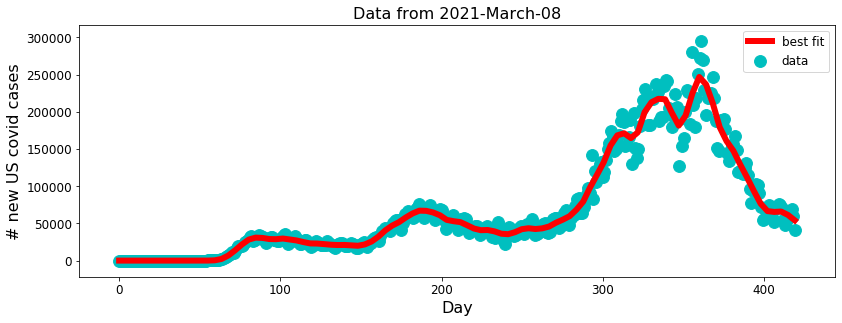

In [18]:
covid = pandas.read_csv('national-history.csv', header=0)
y = covid['positiveIncrease'].values.flatten()
x = np.arange(len(y))[::-1]
BICs, x_grid, fit_y, fx, dfdx, df2dx2 = scan_alphas(x, y, n_gridpoints, alphas, isotonic=0, convexity=0) 

fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(x_grid, fit_y, label='best fit',c='r', lw=6)
ax.scatter(x,y,s=140,c='c',label='data')
ax.set_title('Data from 2021-March-08')
plt.legend()
ax.set_xlabel('Day')
ax.set_ylabel('# new US covid cases')
plt.show()
plt.close()

## Conclusions

Often times working with high volumes of noisy data, we can know some general attributes of our results, but these results can often be distorted from ideal theoretical curves. Molecules can absorb and re-emit light. Reactions can be slightly different from Michaelis Menten curves (or their lambert W integral solutions). Perhaps lasers take a while to warm up, and maybe sometimes the alignments fail giving you a blank result. For all of these situations, this algorithm may be a good fast solution when time is of the essence.


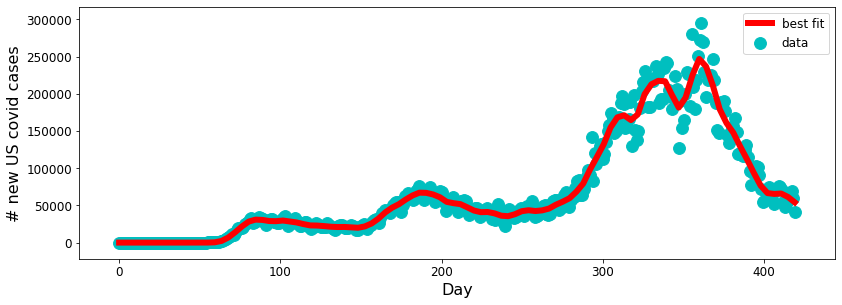